In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

from mpl_toolkits.axes_grid1 import make_axes_locatable

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [47]:
   
db = CaseDB()
toload = [
    dict(name="afnE_base", id = "d24bd-cond0.25_frec0.48"),
    dict(name="afnE_qei_x2", id = "d36a-d28a_qei_x2"),
    dict(name="afnE_qei_x4", id = "d36b-qei_x4"),
    dict(name="afnE_qei_x8", id = "d36c-qei_x8"),
    dict(name="afnE_gammae_2.5", id = "d39a-d28a_gammae_2.5"),
    dict(name="afnE_1e19", id = "d26b-c0.25_f0.48_1e19"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, use_xhermes = False)

- Reading case d24bd-cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 10/16/2023, 10:34:08, dmp file date 10/15/2023, 23:08:48

- Reading case d36a-d28a_qei_x2
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:14:01, dmp file date 12/11/2023, 22:22:45

- Reading case d36b-qei_x4
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:15:07, dmp file date 12/11/2023, 22:04:35

- Reading case d36c-qei_x8
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 13:16:17, dmp file date 12/11/2023, 22:03:39

- Reading case d39a-d28a_gammae_2.5
-----------------------
- Looking for squash file
- Squash file found. squash date 12/21/2023, 11:38:57, dmp file date 12/21/2023, 04:48:11

- Reading case d26b-c0.25_f0.48_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 12/05/2023, 14

In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [48]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_base
Loading afnE_base with new AFN
afnE_qei_x2
Loading afnE_qei_x2 with new AFN
afnE_qei_x4
Loading afnE_qei_x4 with new AFN
afnE_qei_x8
Loading afnE_qei_x8 with new AFN
afnE_gammae_2.5
Loading afnE_gammae_2.5 with new AFN
afnE_1e19
Loading afnE_1e19 with new AFN


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [8]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2"
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Lineplot compare

## 2e19

In [44]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="purple"),
    "SOLPS: 2e19 (full)" : dict(data=sp["nsep_2e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['afnE_base'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = True,
    mode = "log",
    dpi = 120,
    lw = 2
)

KeyError: 'nsep_1e19'

In [45]:
hr.keys()

dict_keys(['afnE_base', 'afnE_qei_x2', 'afnE_qei_x4', 'afnE_qei_x8', 'afnE_gammae_2.5'])

## 1e19

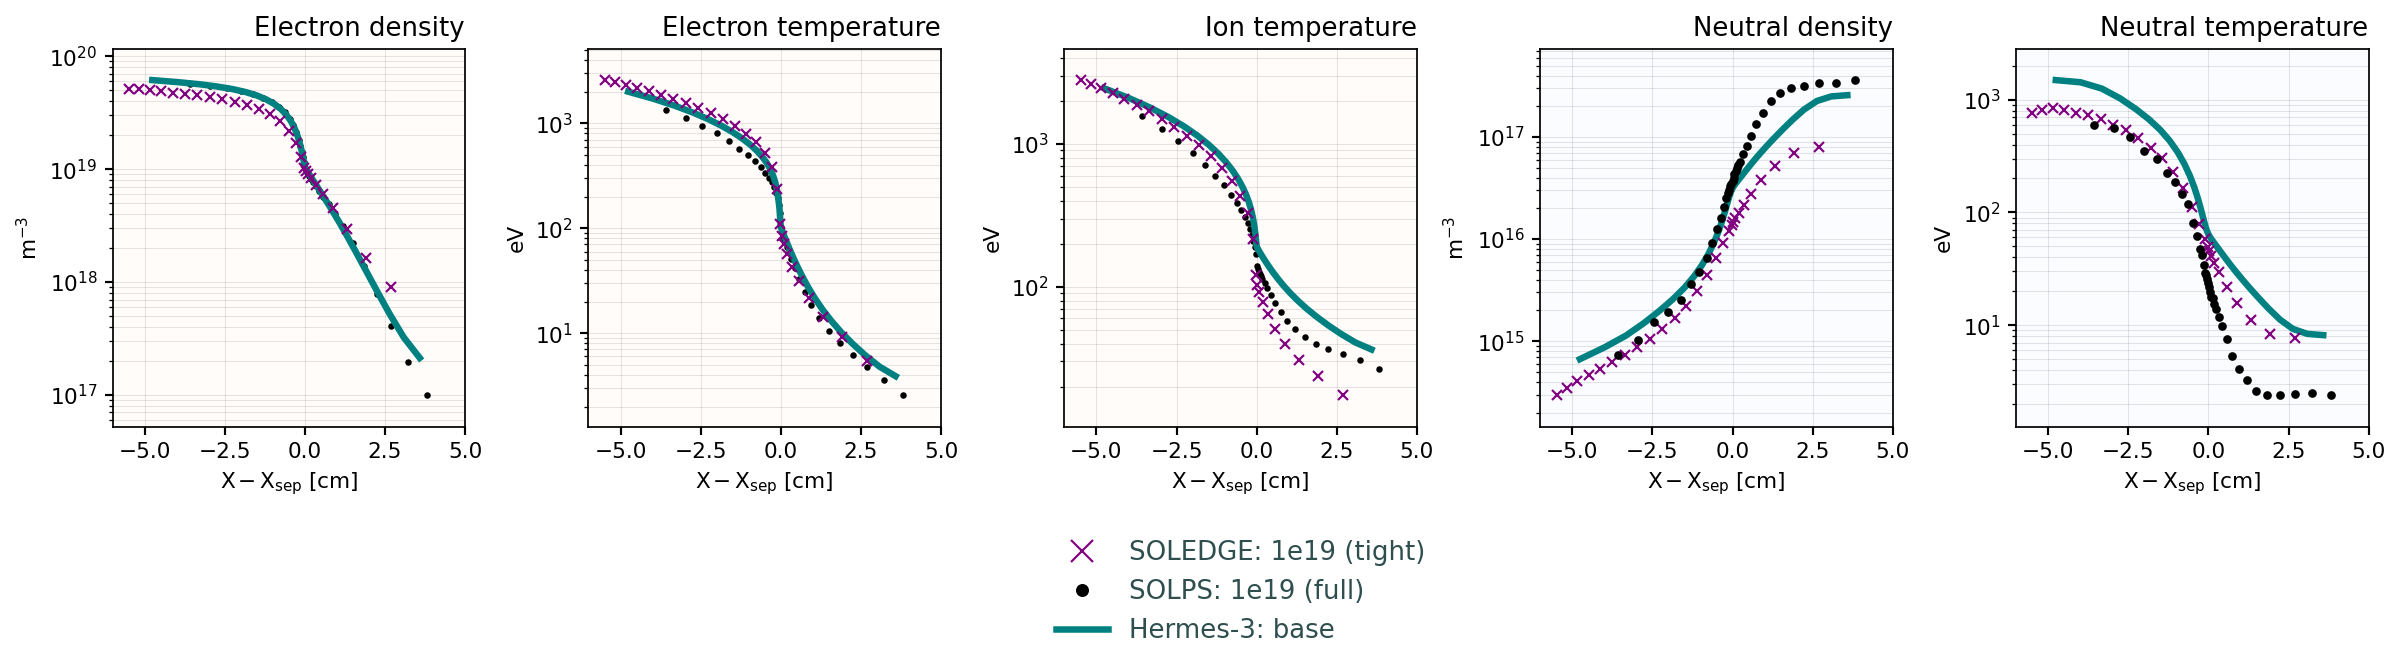

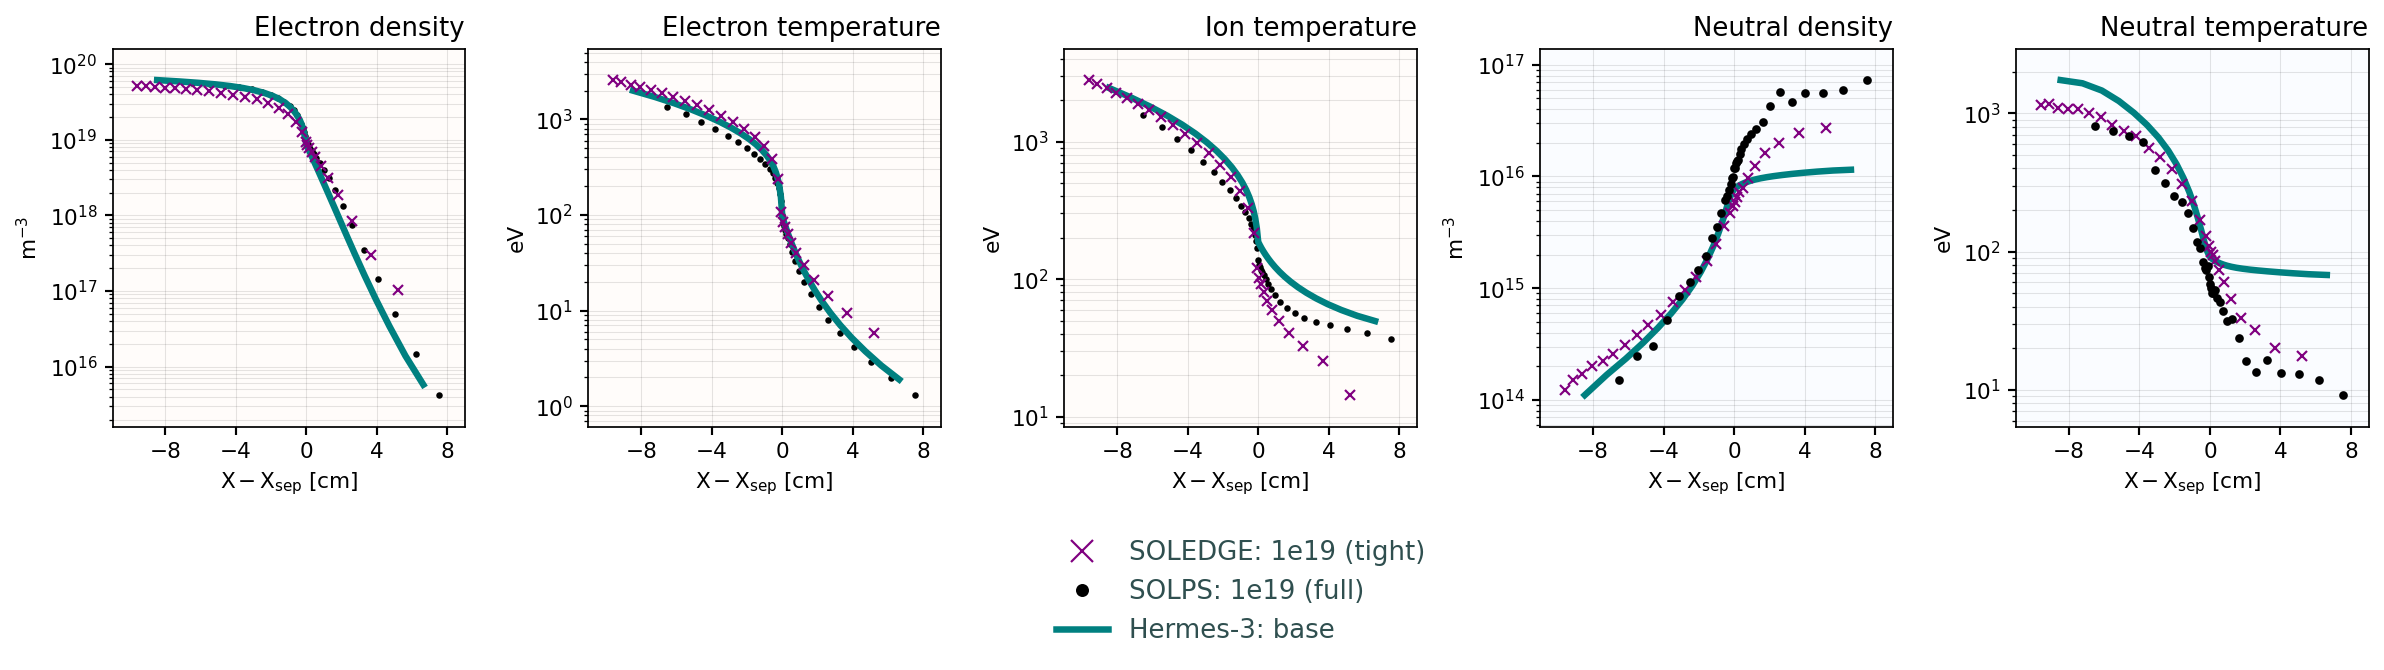

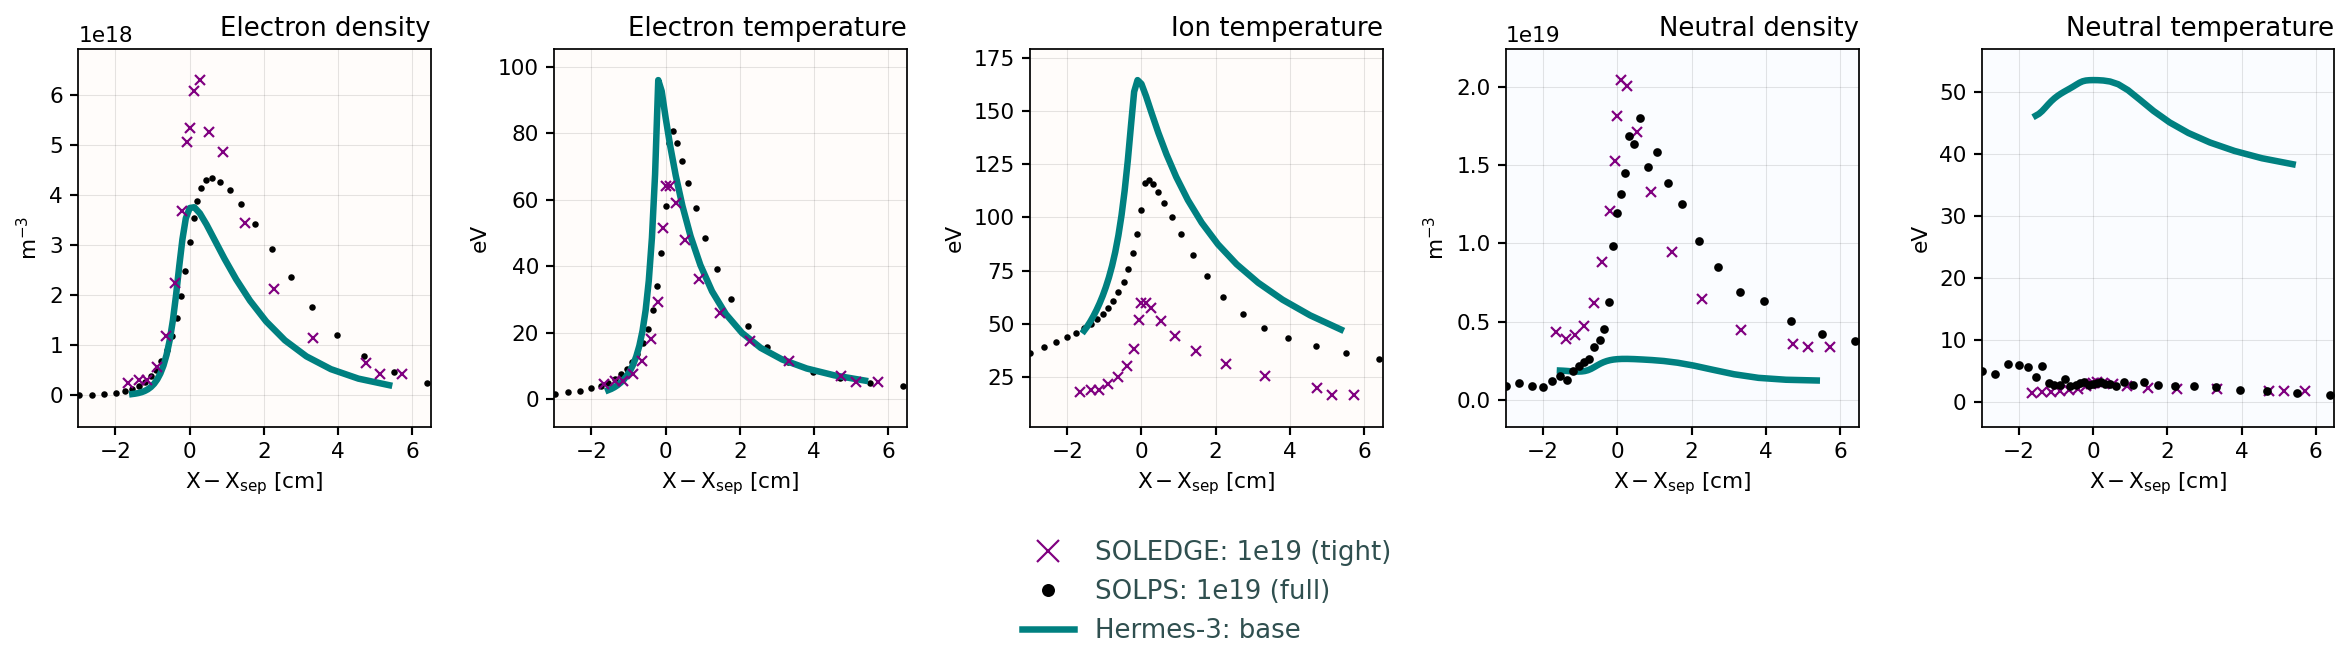

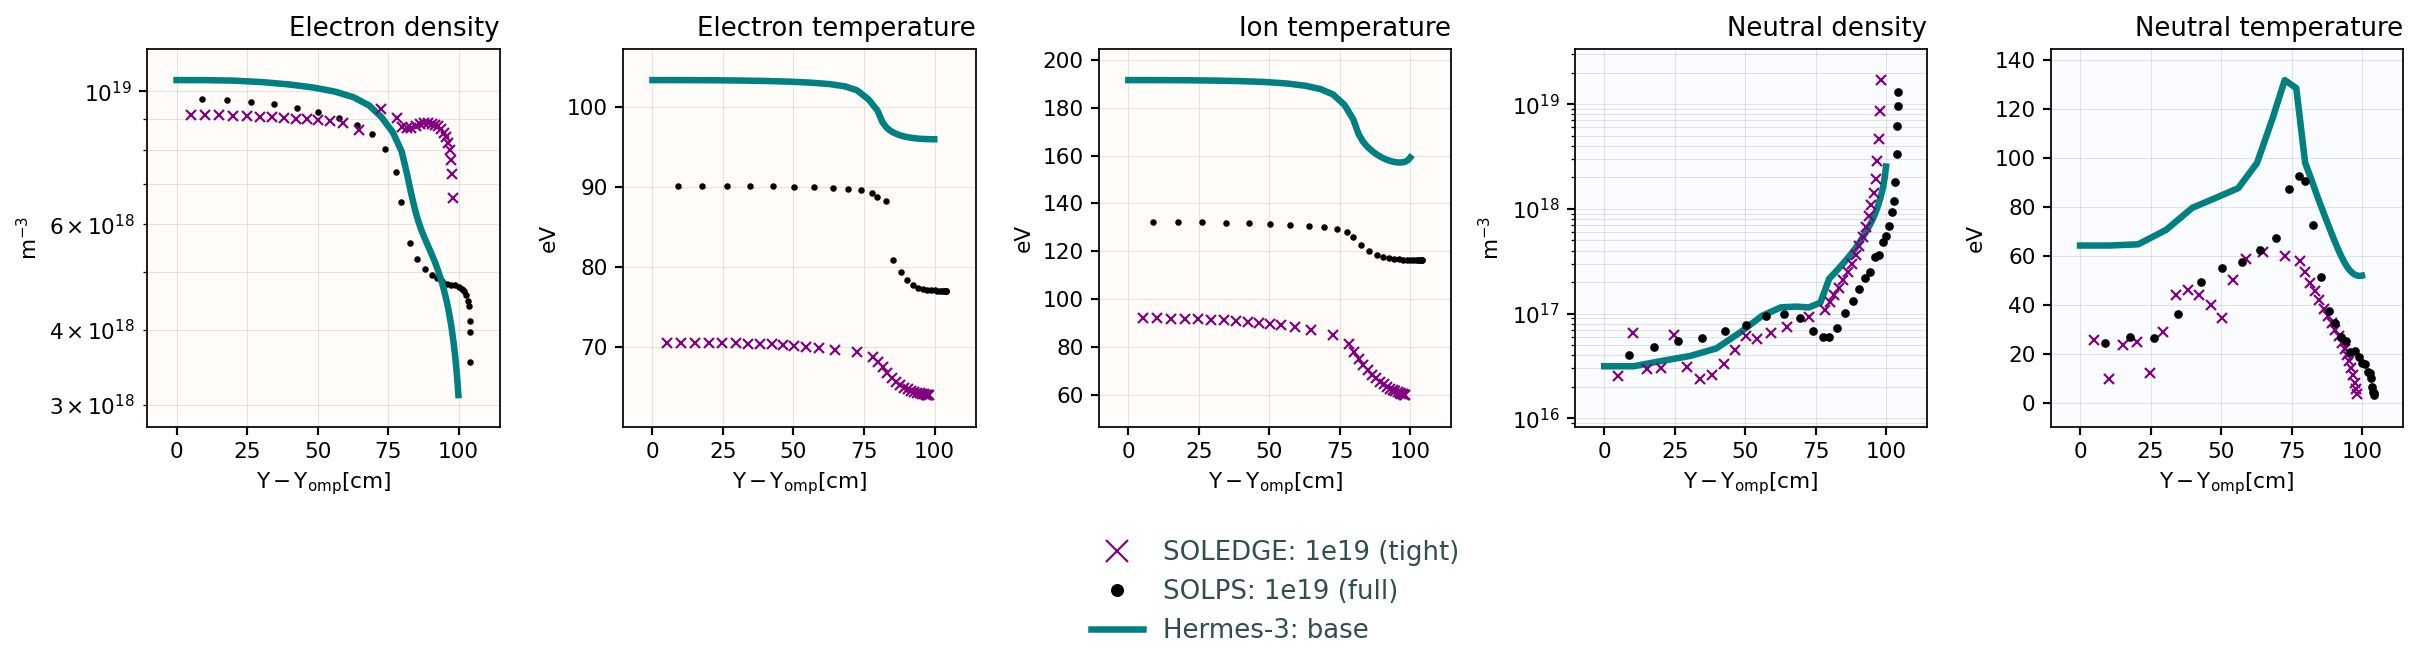

In [49]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 1e19 (tight)" : dict(data=sl["tightwall_1e19"], color="purple"),
    "SOLPS: 1e19 (full)" : dict(data=sp["no_visc"], color="black"),
    r"Hermes-3: base" : dict(data=hr['afnE_1e19'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = True,
    mode = "log",
    dpi = 120,
    lw = 2
)

In [32]:
sp["tightwall_2e19"].regions["omp"].keys()

Index(['Td+', 'Te', 'Ne', 'Pe', 'Pd+', 'Na', 'Nn', 'Nm', 'Ta', 'Tn', 'Tm',
       'Pa', 'Pm', 'Pn'],
      dtype='object')

In [30]:
parse_solps("Na", "omp")

'dab23da'

# Without scaling, comparison with SOLEDGE and SOLPS

In [50]:
sl.keys()

dict_keys(['tightwall_1e19', 'tightwall_2e19', 'widewall_2e19_5m', 'tightwall_3e19', 'widewall_1e19', 'widewall_2e19', 'widewall_3e19'])

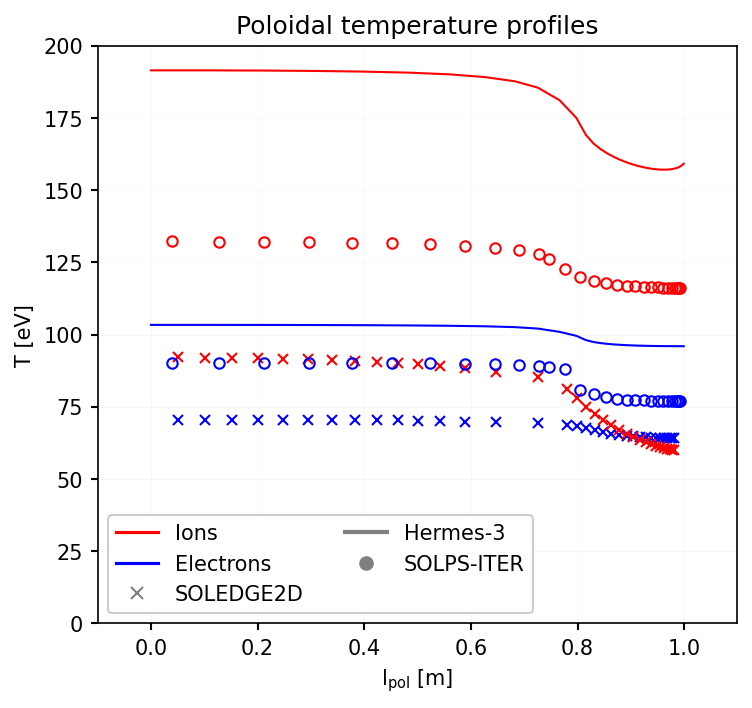

In [52]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

# sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]
# hr_data = hr["afnE_base"].regions["outer_fieldline"]
# sp_data = sp["tightwall_2e19"].regions["outer_fieldline"]

sl_data = sl["tightwall_1e19"].regions["outer_fieldline"]
hr_data = hr["afnE_1e19"].regions["outer_fieldline"]
sp_data = sp["no_visc"].regions["outer_fieldline"]


slstyle = dict(marker = "x", ms = 5, lw = 0)
spstyle = dict(marker = "o", markerfacecolor="None", ms = 5, lw = 0)
hrstyle = dict(lw = 1)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)

ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

ax.plot(sp_data.index-0.05, sp_data["Te"], c = "blue", **spstyle, label = "Electrons")
ax.plot(sp_data.index-0.05, sp_data["Td+"], c = "red", **spstyle, label = "Ions")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")

ax.set_ylim(0,200)
legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 3))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3", "SOLPS-ITER"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# With Qei scaling

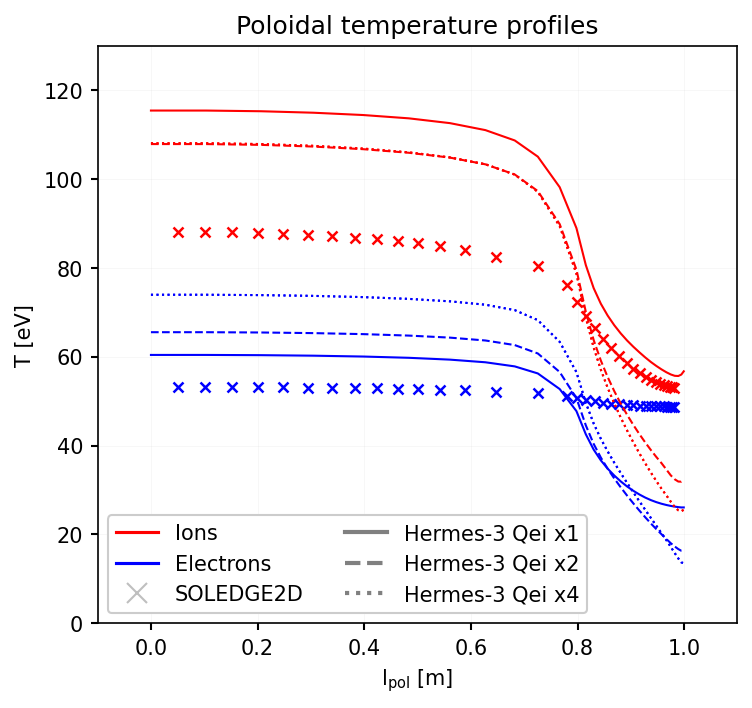

In [26]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]


slstyle = dict(marker = "x", ms = 5, markeredgewidth = 1.2, lw = 0)
spstyle = dict(marker = "o", markerfacecolor="None", ms = 5, lw = 0)
hrstyle = dict(lw = 1)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)


hr_data = hr["afnE_base"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

hr_data = hr["afnE_qei_x2"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = "--")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = "--")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

hr_data = hr["afnE_qei_x4"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = ":")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = ":")

clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")


ax.set_ylim(0,130)
legend_items = []

legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 5, alpha = 0.5))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = "--"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = ":"))
# legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3 Qei x1", "Hermes-3 Qei x2", "Hermes-3 Qei x4"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# With change in gamma

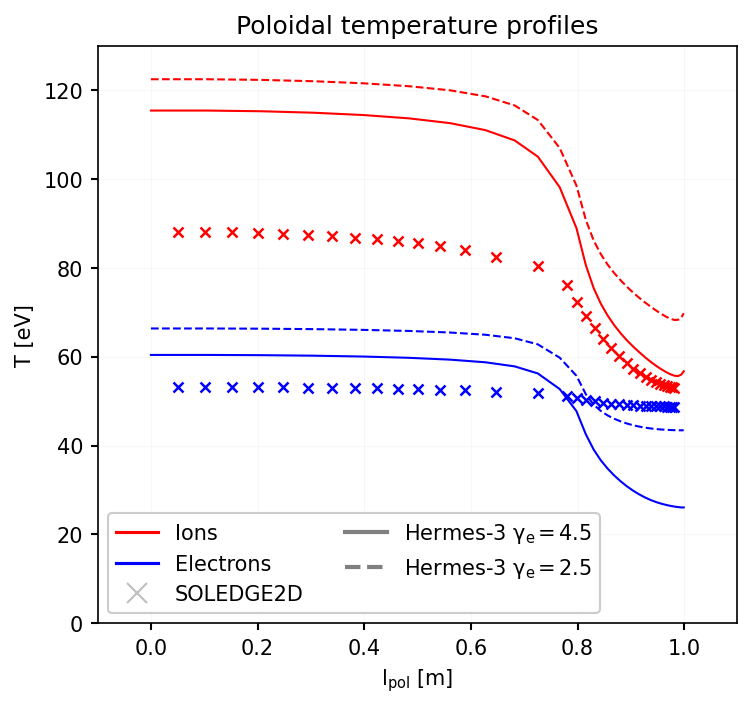

In [25]:
fig, ax = plt.subplots(figsize=(5.5,5),dpi = 150)

sl_data = sl["tightwall_2e19"].regions["outer_fieldline"]


slstyle = dict(marker = "x", ms = 5, markeredgewidth = 1.2, lw = 0)
spstyle = dict(marker = "o", markerfacecolor="None", ms = 5, lw = 0)
hrstyle = dict(lw = 1)

ax.plot(sl_data.index, sl_data["Te"], c = "blue", **slstyle)
ax.plot(sl_data.index, sl_data["Td+"], c = "red", **slstyle)
# ax.plot(sl_data.index, sl_data["Ta"], c = "deeppink", **slstyle)


hr_data = hr["afnE_base"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, label = "Electrons")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, label = "Ions")

hr_data = hr["afnE_gammae_2.5"].regions["outer_fieldline"]
ax.plot(hr_data.index, hr_data["Te"], c = "blue", **hrstyle, ls = "--")
ax.plot(hr_data.index, hr_data["Td+"], c = "red", **hrstyle, ls = "--")


clog = 31 - 0.5 * np.log(sl_data["Ne"]) + np.log(sl_data["Te"])

ax.set_xlabel("$l_{pol}$ [m]")
ax.set_ylabel("T [eV]")
ax.set_title("Poloidal temperature profiles")



legend_items = []
ax.set_ylim(0,130)
legend_items.append(mpl.lines.Line2D([0], [0], color = "red"))
legend_items.append(mpl.lines.Line2D([0], [0], color = "blue"))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "x", ms = 5, alpha = 0.5))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ))
legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 2, ls = "--"))
# legend_items.append(mpl.lines.Line2D([0], [0], color="grey", lw = 0, marker = "o", ms = 3))
ax.legend(legend_items, ["Ions", "Electrons", "SOLEDGE2D", "Hermes-3 $\gamma_{e}=4.5$", "Hermes-3 $\gamma_{e}=2.5$"], fontsize = "medium", loc = "lower left", frameon = True, framealpha = 1,ncols = 2)

# 2D plots

## Ti/Te ratio

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


1.018537486031338 5.5337896964936455


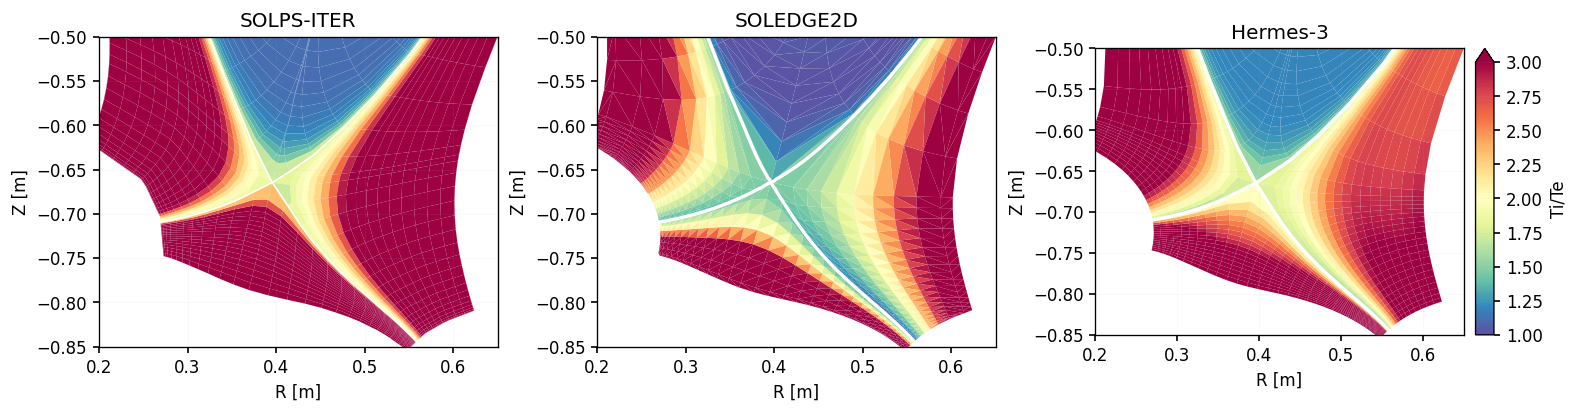

In [95]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

norm = create_norm(False, None, 1, 3)

## SOLPS
spc = SOLPScase(solpscases["tightwall_2e19"])
ratio = spc.bal["ti"] / spc.bal["te"]
spc.plot_2d(r"Ti/Te", norm = norm, data = ratio, cbar = False, logscale = False, ax = axes[0], antialias = True)


## SOLEDGE
slc = SOLEDGEcase(soledgecases["tightwall_2e19"])
Ti = slc._get_2d_on_tri("Tempi")
Te = slc._get_2d_on_tri("Tempe")
ratio = Ti/Te


slc.plot_2d(fig = fig, ax = axes[1], data = ratio, norm = norm, logscale = False, linewidth = 0)


## Hermes-3
ds = casestore["afnE_gammae_2.5"].ds.isel(t=-1)
(ds["Td+"] / ds["Te"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", logscale = False, add_colorbar = False, norm = norm, antialias = True)


for ax in axes.flatten():
    # ax.set_ylim(-0.85, 0.05)
    
    ax.set_xlim(0.2, 0.65)
    ax.set_ylim(-0.85, -0.5)
    
    
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
    
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = "Spectral_r"), cax = cax, label = "Ti/Te", extend = "max")
    
axes[0].set_title("SOLPS-ITER")
axes[1].set_title("SOLEDGE2D")
axes[2].set_title("Hermes-3")
fig.subplots_adjust(wspace = 0.25)

## Te

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


3.502933490724343 2292.3687244122807


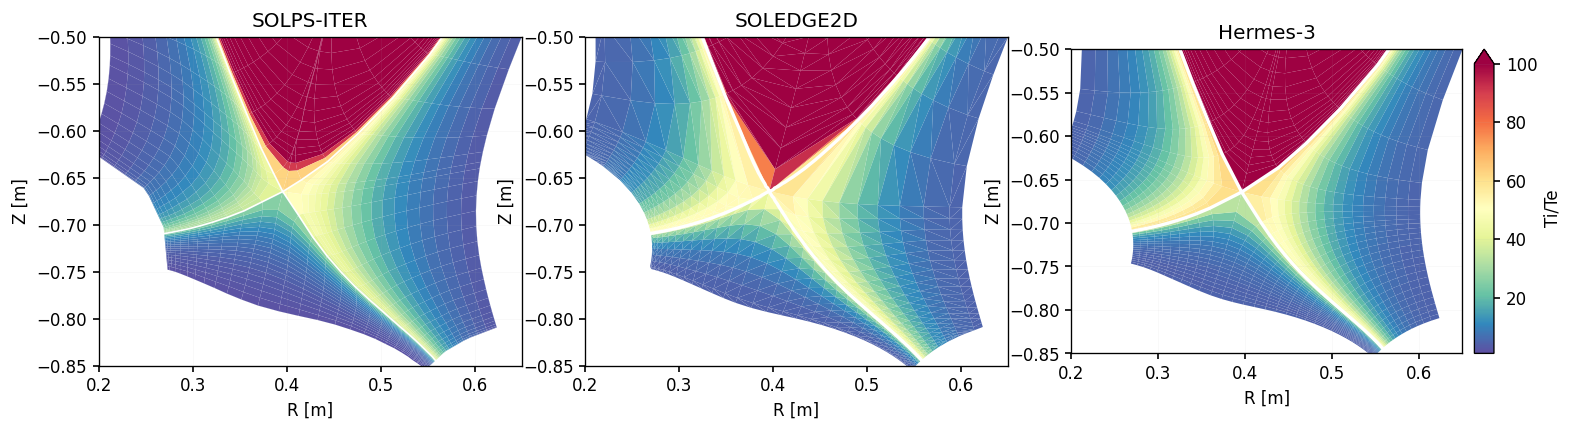

In [90]:
fig, axes = plt.subplots(1,3, figsize = (15,5))

norm = create_norm(False, None, 1, 100)

## SOLPS
spc = SOLPScase(solpscases["tightwall_2e19"])
ratio = spc.bal["te"] / constants("q_e")
spc.plot_2d(r"ti", data = ratio, norm = norm,  cbar = False, logscale = False, ax = axes[0], antialias = True)


## SOLEDGE
slc = SOLEDGEcase(soledgecases["tightwall_2e19"])
Ti = slc._get_2d_on_tri("Tempi")
Te = slc._get_2d_on_tri("Tempe")
ratio = Te
slc.plot_2d(fig = fig, ax = axes[1], data = ratio, norm = norm, logscale = False, linewidth = 0)


## Hermes-3
ds = casestore["afnE_gammae_2.5"].ds.isel(t=-1)
(ds["Te"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", logscale = False, add_colorbar = False, norm = norm, antialias = True)


for ax in axes.flatten():
    ax.set_xlim(0.2, 0.65)
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
    
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mpl.cm.ScalarMappable(norm = norm, cmap = "Spectral_r"), cax = cax, label = "Ti/Te", extend = "max")
    
axes[0].set_title("SOLPS-ITER")
axes[1].set_title("SOLEDGE2D")
axes[2].set_title("Hermes-3")
fig.subplots_adjust(wspace = 0.15)

# Target fluxes

## SOLPS

In [11]:
path = os.path.join(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19\display_tallies.txt")
solps = read_display_tallies(path)

In [12]:
wall_tallies = pd.DataFrame()

all_targets = ["inner_lower_target", "inner_upper_target", "outer_lower_target", "outer_upper_target"]


wall_tallies.loc["hflux_par_e", "solps"] = solps["xreg"].loc["fhexreg", all_targets].abs().sum()*1e-6

# fhixreg: parallel thermal energy flow. 
# fhmxreg: parallel kinetic energy flow. 
# fhtxreg: total energy flow.
# fhjxreg: electrostatic energy flow
# fhpxreg: potential energy flow

wall_tallies.loc["hflux_par_i", "solps"] = solps["xreg"].loc[["fhixreg", "fhmxreg", "fhpxreg", "fhjxreg"],all_targets].abs().sum().sum()*1e-6
wall_tallies.loc["pflux_i", "solps"] = solps["xreg"].loc["fnaxreg", all_targets].abs().sum()
# wall_tallies.loc["hflux_par_tot", "solps"] = solps["xreg"].loc["fhtxreg", all_targets].abs().sum()*1e-6


wall_tallies

,solps
hflux_par_e,5.657270e-01
hflux_par_i,6.867326e-01
pflux_i,3.994610e+22


## SOLEDGE

In [13]:
slc = SOLEDGEcase(soledgecases["tightwall_2e19"])
wfluxes = slc.get_wall_fluxes(split = True, verbose = False)

wfluxes_integral = pd.DataFrame()

params = [x for x in wfluxes["inner_lower_target"].columns if x not in ["R", "Z", 'iTri', 'iSide', 'iProp', 'dlSurf', 'dlWall', 'Area']]

for region in wfluxes.keys():
    for param in params:
        wfluxes_integral.loc[region, param] = (wfluxes[region][param] * wfluxes[region]["Area"]).sum()
        
wfluxes_targets = wfluxes_integral.loc[["inner_lower_target", "outer_lower_target", "outer_upper_target", "inner_upper_target"]].sum()

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed


In [14]:
wall_tallies.loc["hflux_par_e", "soledge"] = wfluxes_targets["E_incident_Electron"] * 1e-6
wall_tallies.loc["hflux_par_i", "soledge"] = wfluxes_targets["E_incident_Ions"] * 1e-6
wall_tallies.loc["pflux_i", "soledge"] = wfluxes_targets["F_Ion_Incident"]
# wall_tallies.loc["pflux_i", "soledge"] = wfluxes_targets["F_ion_incident"]

## Hermes-3

In [15]:
ds = casestore["afnE_base"].ds.isel(t=-1)
ds = calculate_target_fluxes(ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


In [16]:
wall_tallies["hermes"] = float(0)

tally = 0
for target in ["inner_lower_target", "inner_upper_target", "outer_lower_target", "outer_upper_target"]:
    wall_tallies.loc["hflux_par_e", "hermes"] += ds[f"hf_{target}_e"].sum("x").values * -1e-6
    wall_tallies.loc["hflux_par_i", "hermes"] += ds[f"hf_{target}_d+"].sum("x").values * -1e-6
    # wall_tallies.loc["hflux_par_i", "hermes"] += ds["hf_par_i_" + target].sum()
    wall_tallies.loc["pflux_i", "hermes"] += ds[f"pf_{target}_d+"].sum("x").values *-1

wall_tallies

,solps,soledge,hermes
hflux_par_e,5.657270e-01,5.539301e-01,6.572688e-01
hflux_par_i,6.867326e-01,9.633298e-01,1.072211e+00
pflux_i,3.994610e+22,4.872728e+22,5.519047e+22


# Target fluxes & gamma calc

In [24]:
target_tallies = pd.DataFrame()

## SOLPS
target_tallies.loc["hflux_par_e", "solps"] = solps["xreg"].loc["fhexreg", "outer_lower_target"]*1e-6
target_tallies.loc["hflux_par_i", "solps"] = solps["xreg"].loc[["fhixreg", "fhmxreg", "fhpxreg", "fhjxreg"],"outer_lower_target"].sum()*1e-6
target_tallies.loc["pflux_i", "solps"] = solps["xreg"].loc["fnaxreg", "outer_lower_target"]

## SOLEDGE
wfluxes_target = wfluxes_integral.loc[["outer_lower_target"]].sum()
target_tallies.loc["hflux_par_e", "soledge"] = wfluxes_target["E_incident_Electron"] * 1e-6
target_tallies.loc["hflux_par_i", "soledge"] = wfluxes_target["E_incident_Ions"] * 1e-6
target_tallies.loc["pflux_i", "soledge"] = wfluxes_target["F_Ion_Incident"]

## Hermes-3
target = "outer_lower_target"

target_tallies.loc["hflux_par_e", "hermes"] = ds[f"hf_{target}_e"].sum("x").values * -1e-6
target_tallies.loc["hflux_par_i", "hermes"] = ds[f"hf_{target}_d+"].sum("x").values * -1e-6
target_tallies.loc["pflux_i", "hermes"] = ds[f"pf_{target}_d+"].sum("x").values *-1

target_tallies

,solps,soledge,hermes
hflux_par_e,2.128700e-01,2.189454e-01,2.536448e-01
hflux_par_i,2.574534e-01,3.666358e-01,4.113751e-01
pflux_i,1.418700e+22,1.961381e+22,2.266780e+22


In [ ]:
wall_tallies.loc["Tt_avg", "solps"] = sp["tightwall_2e19"].regions["outer_lower"]

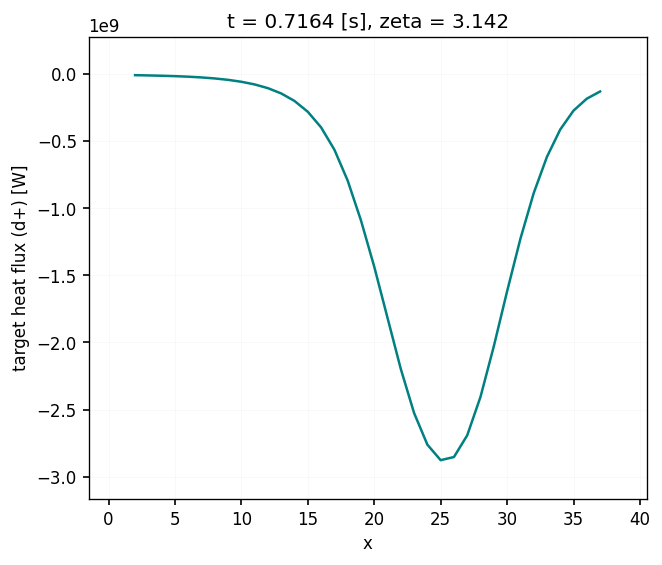

In [198]:
(ds["hf_outer_lower_target_d+"]).plot()

In [187]:
wall_tallies

,solps,soledge,hermes
hflux_par_e,5.657270e-01,5.539301e-01,-5.246557e+10
hflux_par_i,6.867326e-01,9.633298e-01,0.000000e+00
pflux_i,3.994610e+22,4.872728e+22,-4.405503e+27


In [ ]:
calculate_heat_balance(ds)

In [185]:
ds["hf_inner_lower_target_d+"].sum().values

array(-1.00013005e+10)

In [175]:
[print(x) for x in ds.data_vars if "target" in x]

Ed_target_recycle
Ed_target_refl
Sd_target_recycle
hf_inner_lower_target_e
hf_inner_lower_target_d+
pf_inner_lower_target_d+
hf_outer_lower_target_e
hf_outer_lower_target_d+
pf_outer_lower_target_d+
hf_inner_upper_target_e
hf_inner_upper_target_d+
pf_inner_upper_target_d+
hf_outer_upper_target_e
hf_outer_upper_target_d+
pf_outer_upper_target_d+
pf_recycle_inner_lower_target_d
hf_recycle_inner_lower_target_d
pf_recycle_outer_lower_target_d
hf_recycle_outer_lower_target_d
pf_recycle_inner_upper_target_d
hf_recycle_inner_upper_target_d
pf_recycle_outer_upper_target_d
hf_recycle_outer_upper_target_d


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [171]:
wall_tallies

,solps,soledge
hflux_par_e,5.657270e-01,5.539301e-01
hflux_par_i,6.867326e-01,9.633298e-01
pflux_i,3.994610e+22,4.872728e+22
hflux_par_tot,1.761450e+00,NaN


In [164]:
wall

,F_Ion_Incident,F_Atom_Emitted_from_Ion,F_Atom_Incident,F_Mol_Incident,F_Mol_Emitted_from_Ion,F_Atom_Emitted_from_Atom,F_Mol_Emitted_from_Atom,E_incident_Electron,E_incident_Ions,E_Total,E_incident_Atoms,E_Radiation_Atoms,E_Rad_Recombination,E_Recombination_in_Wall,E_incident_Molecules,E_incident_Ions_EIRENE,E_Radiation
inner_lower_target,5.184224e+21,3.068479e+21,1.433211e+21,2.347242e+19,1.057872e+21,1.081636e+21,1.757872e+20,59218.584096,109790.411915,144565.480822,10419.722158,3852.975483,-50447.439312,11731.228064,0.0,140842.559883,3852.975483
lower_pfr,0.000000e+00,0.000000e+00,7.146816e+21,2.284701e+20,0.000000e+00,5.555425e+21,7.956956e+20,0.000000,0.000000,50384.018702,39600.593976,10502.954702,0.000000,280.469954,0.0,0.000000,10502.954702
outer_lower_target,1.961381e+22,1.176788e+22,7.839288e+21,4.134471e+20,3.922970e+21,6.039355e+21,8.999666e+20,218945.397587,366635.826414,487913.228306,26179.762019,6267.420896,-174553.538084,44438.354150,0.0,484000.024072,6267.420896
outer_wall,0.000000e+00,0.000000e+00,1.845098e+22,9.846037e+20,0.000000e+00,1.371612e+22,1.777601e+21,0.000000,0.000000,232056.518049,210326.218488,21103.723978,0.000000,626.575781,0.0,0.000000,21103.723978
outer_upper_target,1.888751e+22,1.127454e+22,5.894557e+21,2.057956e+20,3.806484e+21,4.587803e+21,6.533773e+20,217753.857724,382543.286304,493835.074551,23038.758538,6002.660551,-178231.240698,42727.752749,0.0,498164.002205,6002.660551
upper_pfr,1.304832e+20,8.758513e+19,7.015190e+21,2.280672e+20,2.144904e+19,5.477885e+21,7.686521e+20,234.454640,1283.252733,52289.724924,42042.703928,8769.980924,-603.487202,562.819866,0.0,1356.305821,8769.980924
inner_upper_target,5.041735e+21,2.990428e+21,1.393611e+21,2.224302e+19,1.025654e+21,1.048839e+21,1.723859e+20,58012.247379,104360.321702,139484.891171,10880.560926,3226.749130,-48403.178465,11408.189870,0.0,134609.182653,3226.749130
inner_wall,0.000000e+00,0.000000e+00,9.785157e+20,1.825320e+19,0.000000e+00,7.058009e+20,1.363574e+20,0.000000,0.000000,38566.635689,26182.268889,12336.303017,0.000000,48.063812,0.0,0.000000,12336.303017


In [165]:


wfluxes_targets

F_Ion_Incident              4.872728e+22
F_Atom_Emitted_from_Ion     2.910132e+22
F_Atom_Incident             1.656067e+22
F_Mol_Incident              6.649581e+20
F_Mol_Emitted_from_Ion      9.812980e+21
F_Atom_Emitted_from_Atom    1.275763e+22
F_Mol_Emitted_from_Atom     1.901517e+21
E_incident_Electron         5.539301e+05
E_incident_Ions             9.633298e+05
E_Total                     1.265799e+06
E_incident_Atoms            7.051880e+04
E_Radiation_Atoms           1.934981e+04
E_Rad_Recombination        -4.516354e+05
E_Recombination_in_Wall     1.103055e+05
E_incident_Molecules        0.000000e+00
E_incident_Ions_EIRENE      1.257616e+06
E_Radiation                 1.934981e+04
dtype: float64